In [1]:
import math as m
import random
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import statsmodels.regression.linear_model as sm

In [2]:
# length of manipulators
l1 = l2 = l3 = 7
n = 4
ITERATIONS = 20

In [3]:
initial_joint_pos = [[0, 0], [0, l1], [0, l1+l2], [0, l1+l2+l3]]
d = [l1, l2, l3]

In [4]:
def calculate_distance(p1, p2):
    return m.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [5]:
def forward_reaching(joint_pos, target):
    joint_pos[n-1] = copy.deepcopy(target)
    
    for i in reversed(range(n-1)):
        dist = calculate_distance(joint_pos[i+1], joint_pos[i])
        m = d[i]/dist
        
        joint_pos[i][0] = (1-m)*joint_pos[i+1][0] + m*joint_pos[i][0]
        joint_pos[i][1] = (1-m)*joint_pos[i+1][1] + m*joint_pos[i][1]

In [6]:
def backward_reaching(joint_pos, b):
    joint_pos[0] = copy.deepcopy(b)
    
    for i in range(n-1):
        dist = calculate_distance(joint_pos[i+1], joint_pos[i])
        m = d[i]/dist
        
        joint_pos[i+1][0] = (1-m)*joint_pos[i][0] + m*joint_pos[i+1][0]
        joint_pos[i+1][1] = (1-m)*joint_pos[i][1] + m*joint_pos[i+1][1]

In [7]:
def fabric(joint_pos, target):
#     print(initial_joint_pos)
    if(calculate_distance(joint_pos[0], target) > l1 + l2 + l3):
        # Target is unreachable.
        print("Target is unreachable.")
        return
    
    # Target is reachable.
    # Store the initial position of the base joint.
    b = copy.deepcopy(joint_pos[0])
    
    dif = calculate_distance(joint_pos[n-1], target)
    
    iter = 0
    while(dif > 0.01 and iter < ITERATIONS):
        # Stage 1: Forward Reaching
        forward_reaching(joint_pos, target)
        
#         print("\nForward Reaching")
#         print(joint_pos[n-1])
#         print(joint_pos[0])
        
        # Stage 2: Backward Reaching
        backward_reaching(joint_pos, b)
        
#         print("\nBackward Reaching")
#         print(joint_pos[n-1])
#         print(joint_pos[0])
#         print(b)
        
        dif = calculate_distance(joint_pos[n-1], target)
        iter += 1
#         print("Distance =", dif)
#         print("--------------")

In [8]:
joint_pos = copy.deepcopy(initial_joint_pos)
print(joint_pos)
fabric(joint_pos, [5, 7])

[[0, 0], [0, 7], [0, 14], [0, 21]]


In [9]:
for i in range(3):
    print(calculate_distance(joint_pos[i], joint_pos[i+1]))

6.999999999999998
7.000000000000001
6.999999999999999


In [10]:
from sklearn.metrics import mean_squared_error

def getPerformanceModel(filename):
    data=pd.read_csv(filename)

    X_true=data['xe']
    X_pred=data['t1']
    rmse_x=mean_squared_error(X_true,X_pred)

    Y_true=data['ye']
    Y_pred=data['t2']
    rmse_y=mean_squared_error(Y_true,Y_pred) 

    print('\nrmse in x = ', rmse_x) 
    print('rmse in y = ', rmse_y)

    ## adjusted rsquared test
    regressor_OLS = sm.OLS(endog = X_true, exog = X_pred).fit() 
    print(regressor_OLS.rsquared_adj)
    regressor_OLS = sm.OLS(endog = Y_true, exog = Y_pred).fit() 
    print(regressor_OLS.rsquared_adj) 

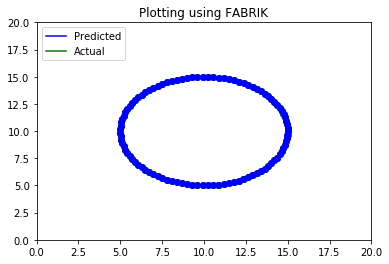

In [11]:
## trying to plot "Circle"

def circleFabrikFile():
    with open('circle_fabrik.csv', 'w') as csvFile:
        row = ['xe','ye','thetae','t1','t2','t3']
        csv.writer(csvFile).writerow(row)
        Xc = 10
        Yc = 10
        r = 5
        data_points =100
        points = np.linspace(0,360,num =data_points)
        
        joint_pos = copy.deepcopy(initial_joint_pos)
        print(joint_pos)
        
        for p in points:
            i=Xc + r*m.cos(np.radians(p))
            j=Yc + r*m.sin(np.radians(p))
            theta=m.degrees(m.atan(j/i))
            
            # new_x=np.array([[i, j, theta]])
            
            fabric(joint_pos, [i, j])
            
            
            t1= joint_pos[n-1][0]
            t2= joint_pos[n-1][1]
            
            t3= m.degrees(m.atan(t2/t1))
            
            row = [i,j,theta,t1,t2,t3]
            # plt.xlim([0,20])
            # plt.ylim([0,20])
            plt.plot(i,j,'go')
            csv.writer(csvFile).writerow(row)
                
    csvFile.close()
    
# circleFabrikFile()
joint_pos = copy.deepcopy(initial_joint_pos)
filename = 'circle_fabrik.csv'
data = np.loadtxt(filename, delimiter=",", skiprows=1)

actual_coordinates = [row[0:2].tolist() for row in data]

for coord in actual_coordinates:
    plt.plot(coord[0], coord[1], 'go')

pred_coordinates = [row[3:5].tolist() for row in data]

for coord in pred_coordinates:
    plt.plot(coord[0], coord[1], 'bo')

plt.xlim([0,20])
plt.ylim([0,20])
plt.plot(20, 20, 'b', label='Predicted')
plt.plot(20, 20, 'g', label='Actual')
plt.title('Plotting using FABRIK')
plt.legend(loc='upper left')
plt.savefig('Fabrik-CirclePlot.png')

In [12]:
getPerformanceModel('circle_fabrik.csv')


rmse in x =  1.5812985749035916e-05
rmse in y =  5.992965895489817e-06
0.999999861673314
0.9999999602760429


In [13]:
def plotFile(filename, X_pred, Y_pred):
    joint_pos = copy.deepcopy(initial_joint_pos)
#     filename = 'manit.csv'
    data = np.loadtxt(filename, delimiter=",", skiprows=1)

    actual_coordinates = [row[3:5].tolist() for row in data]

    for coord in actual_coordinates:
        plt.plot(coord[0], coord[1], 'go')

        fabric(joint_pos, coord)

        plt.plot(joint_pos[n-1][0], joint_pos[n-1][1], 'bo')

        X_pred.append(joint_pos[n-1][0])
        Y_pred.append(joint_pos[n-1][1])

    plt.xlim([0,22])
    plt.ylim([0,22])
    plt.plot(20, 20, 'b', label='Predicted')
    plt.plot(20, 20, 'g', label='Actual')
    plt.title('Plotting using FABRIK')
    plt.legend(loc='upper left')
#     plt.savefig('Fabrik-Robot.png')

In [14]:
# Performance on "MANIT"
def getRMSE(filename, xPredicted, yPredicted):
    data = pd.read_csv(filename)
    X_true = data['xe']
    X_pred = pd.Series(xPredicted) 
    rmse_x=mean_squared_error(X_true,X_pred)

    Y_true = data['ye']
    Y_pred = pd.Series(yPredicted) 
    rmse_y=mean_squared_error(Y_true,Y_pred) 

    print('RMSE in x = ', rmse_x) 
    print('RMSE in y = ', rmse_y)

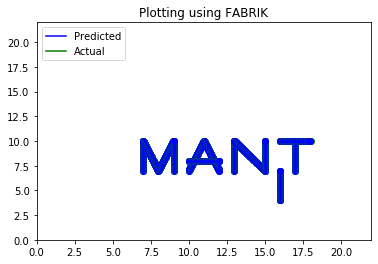

In [15]:
X_pred = []
Y_pred = []

plotFile('manit.csv', X_pred, Y_pred)

In [16]:
getRMSE('manit.csv', X_pred, Y_pred)

RMSE in x =  1.033734226999892e-05
RMSE in y =  1.285064602793001e-06


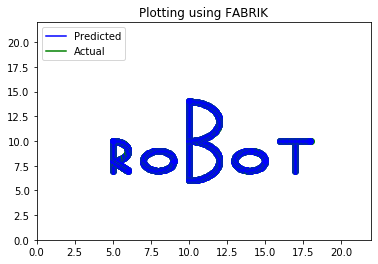

In [17]:
X_pred = []
Y_pred = []

plotFile('robot.csv', X_pred, Y_pred)

In [18]:
getRMSE('robot.csv', X_pred, Y_pred)

RMSE in x =  1.5450325671019387e-05
RMSE in y =  7.302049992124614e-06


## Calculating Average Number of Iterations Required

In [19]:
def fabric_other(joint_pos, target):
    if(calculate_distance(joint_pos[0], target) > l1 + l2 + l3):
        # Target is unreachable.
        print("Target is unreachable.")
        return
    
    # Target is reachable.
    # Store the initial position of the base joint.
    b = copy.deepcopy(joint_pos[0])
    
    dif = calculate_distance(joint_pos[n-1], target)
    
    iter = 0
    while(dif > 0.01):
        # Stage 1: Forward Reaching
        forward_reaching(joint_pos, target)
        
        # Stage 2: Backward Reaching
        backward_reaching(joint_pos, b)
        
        dif = calculate_distance(joint_pos[n-1], target)
        iter += 1
    
    return iter

In [20]:
def avgIterationForFile(filename, X_pred, Y_pred):
    data = np.loadtxt(filename, delimiter=",", skiprows=1)

    actual_coordinates = [row[3:5].tolist() for row in data]
    
    sum = 0
    num_coordinates = 0
    for coord in actual_coordinates:
        joint_pos = copy.deepcopy(initial_joint_pos)
        
        plt.plot(coord[0], coord[1], 'go')

        iter = float(fabric_other(joint_pos, coord))
        sum += iter
#         print(iter)

        plt.plot(joint_pos[n-1][0], joint_pos[n-1][1], 'bo')

        X_pred.append(joint_pos[n-1][0])
        Y_pred.append(joint_pos[n-1][1])
        num_coordinates += 1
    
#     num_coordinates = float(len(actual_coordinates))
    plt.xlim([0,22])
    plt.ylim([0,22])
    plt.plot(20, 20, 'b', label='Predicted')
    plt.plot(20, 20, 'g', label='Actual')
    plt.title('Plotting using FABRIK')
    plt.legend(loc='upper left')
#     plt.savefig('Fabrik-Robot.png')
    
    print(sum)
    print(num_coordinates)
    
    return sum/num_coordinates 

5377.0
1300


4.136153846153846

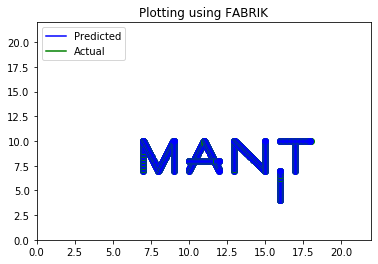

In [21]:
# Average Iterations for "MANIT"
X_pred = []
Y_pred = []

avgIterationForFile('manit.csv', X_pred, Y_pred)

5204.0
1000


5.204

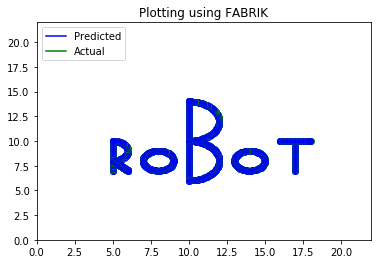

In [22]:
# Average Iterations for "ROBOT"
X_pred = []
Y_pred = []

avgIterationForFile('robot.csv', X_pred, Y_pred)